# Overview

This notebook provides an overview of applying Howso Engine to make predictions based on historical data and harnessing Howso Engine’s interpretability capabilities to understand why the predictions were made. Here, we demonstrate these capabilities on vehicle data. We train Howso Engine to predict classes of vehicles, understand potential anomalies, investigate vehicles on a case-by-case basis, and review the data that contributed to the predictions. This is a straightforward example of the power of Howso Engine to gain insights from data. 

In [1]:
import os

import pandas as pd
import plotly.io as pio
from sklearn.metrics import (
    accuracy_score,
    f1_score,
)

from howso import engine
from howso.utilities import infer_feature_attributes
from howso.visuals import plot_dataset

pio.renderers.default = os.getenv("HOWSO_RECIPE_RENDERER", "notebook")

# Supervised ML

## 1. Load Data

The last column, vehicle class, is our target variable. We'll use the other variables (with the exception of make and model, as this would be too easy) to build a model. 

In [2]:
df = pd.read_csv('data/vehicle_processed.csv')

# drop any duplicate records
df = df.drop_duplicates()

# keep a copy of the original data for later reference Make & Model
df_original = df.copy()

df = df.drop(['Make', 'Model'], axis=1)
df

,CityMPG,DriveType,FuelType,HighwayMPG,Year,PassengerVolume,LuggageVolume,VehicleClass
0,23,Front-Wheel Drive,Regular,33,1985,77,19,Subcompact Cars
1,17,4-Wheel or All-Wheel Drive,Premium,23,1993,90,14,Compact Cars
2,21,Front-Wheel Drive,Regular,24,1993,88,15,Compact Cars
3,22,Front-Wheel Drive,Regular,29,1993,88,15,Compact Cars
4,23,Front-Wheel Drive,Regular,26,1993,89,13,Compact Cars
...,...,...,...,...,...,...,...,...
23600,21,Front-Wheel Drive,Regular,32,1993,89,12,Compact Cars
23601,19,Front-Wheel Drive,Regular,26,1993,90,14,Compact Cars
23602,20,Front-Wheel Drive,Regular,28,1993,90,14,Compact Cars
23603,18,4-Wheel or All-Wheel Drive,Regular,24,1993,90,14,Compact Cars


NOTE: Howso Engine can work with missing values natively

In [3]:
df.isnull().sum()

CityMPG              0
DriveType          783
FuelType             0
HighwayMPG           0
Year                 0
PassengerVolume      0
LuggageVolume        0
VehicleClass         0
dtype: int64

In [4]:
df[df.DriveType.isnull()]

,CityMPG,DriveType,FuelType,HighwayMPG,Year,PassengerVolume,LuggageVolume,VehicleClass
9707,15,NaN,Regular,20,1984,50,22,Two Seaters
9708,16,NaN,Regular,20,1984,50,22,Two Seaters
9709,16,NaN,Regular,22,1984,50,22,Two Seaters
9710,18,NaN,Regular,24,1984,50,22,Two Seaters
9711,17,NaN,Regular,24,1984,74,7,Minicompact Cars
...,...,...,...,...,...,...,...,...
10848,14,NaN,Regular,19,1984,110,50,Midsize-Large Station Wagons
10849,13,NaN,Regular,19,1984,112,53,Midsize-Large Station Wagons
10850,13,NaN,Regular,19,1984,112,53,Midsize-Large Station Wagons
10851,13,NaN,Regular,20,1984,110,50,Midsize-Large Station Wagons


In [5]:
labels = df['VehicleClass'].unique()
list(labels)

['Subcompact Cars',
 'Compact Cars',
 'Midsize Cars',
 'Large Cars',
 'Small Station Wagons',
 'Midsize-Large Station Wagons',
 'Minicompact Cars',
 'Two Seaters',
 'Midsize Station Wagons',
 'Special Purpose Vehicle 4WD',
 'Sport Utility Vehicle - 4WD',
 'Sport Utility Vehicle - 2WD',
 'Small Pickup Trucks 4WD',
 'Small Sport Utility Vehicle 4WD',
 'Small Sport Utility Vehicle 2WD',
 'Special Purpose Vehicle 2WD',
 'Standard Sport Utility Vehicle 2WD',
 'Standard Sport Utility Vehicle 4WD']

## 2. Train model

For the purpose of this demo we will use the older cars in the dataset to predict newer cars.

In [6]:
test_index = df[df['Year'].isin([2021])].index
train_index = df[~df['Year'].isin([2021])].index

# train & test size
print("train size (ratio): " + str(round(len(train_index) / df.shape[0], 2) ))
print("test size (ratio): " + str(round(len(test_index) / df.shape[0], 2) ) )

train size (ratio): 0.97
test size (ratio): 0.03


In [7]:
df_train = df.loc[train_index, :]
X_test = df.loc[test_index, :].drop('VehicleClass', axis=1)
y_test = df.loc[test_index, 'VehicleClass']

In [8]:
# explicitly specify continuous features
custom_features = {}

cont_features = ['CityMPG', 'HighwayMPG', 'PassengerVolume', 'LuggageVolume', 'Year']

for ft in cont_features:
    custom_features[ft] = {'type': 'continuous'}

# infer features using dataframe format
features = infer_feature_attributes(df, features=custom_features)

features

{'CityMPG': {'type': 'continuous',
  'data_type': 'number',
  'decimal_places': 0,
  'original_type': {'data_type': 'integer', 'size': 8},
  'bounds': {'allow_null': False}},
 'HighwayMPG': {'type': 'continuous',
  'data_type': 'number',
  'decimal_places': 0,
  'original_type': {'data_type': 'integer', 'size': 8},
  'bounds': {'allow_null': False}},
 'PassengerVolume': {'type': 'continuous',
  'data_type': 'number',
  'decimal_places': 0,
  'original_type': {'data_type': 'integer', 'size': 8},
  'bounds': {'allow_null': False}},
 'LuggageVolume': {'type': 'continuous',
  'data_type': 'number',
  'decimal_places': 0,
  'original_type': {'data_type': 'integer', 'size': 8},
  'bounds': {'allow_null': False}},
 'Year': {'type': 'continuous',
  'data_type': 'number',
  'decimal_places': 0,
  'original_type': {'data_type': 'integer', 'size': 8},
  'bounds': {'allow_null': False}},
 'DriveType': {'type': 'nominal', 'original_type': {'data_type': 'string'}},
 'FuelType': {'type': 'nominal', '

In [9]:
# specify context and action features
context_features = features.get_names(without=['VehicleClass'])
action_features = ['VehicleClass']

# create the trainee
t = engine.Trainee(name='Engine - Car Type Recipe', 
                    features=features, 
                    overwrite_existing=True)

# train the trainee
t.train(df_train)

# analyze
t.analyze()

## 3. Predict

In [10]:
results = t.react(X_test, action_features=action_features, context_features=context_features)
predictions = results['action']['VehicleClass']

In [11]:
accuracy_score = round(accuracy_score(y_test, predictions), 3)
print(accuracy_score)

0.926


How accurately can we predict vehicle classes?

In [12]:
score = f1_score(y_test, predictions, average=None)

In [13]:
for i in range(0, len(set(y_test))): 
    print(labels[i] + ': ' + str(round(score[i], 3)))

Subcompact Cars: 0.938
Compact Cars: 0.898
Midsize Cars: 0.918
Large Cars: 0.909
Small Station Wagons: 0.986
Midsize-Large Station Wagons: 0.857
Minicompact Cars: 0.8
Two Seaters: 0.846
Midsize Station Wagons: 1.0
Special Purpose Vehicle 4WD: 0.667
Sport Utility Vehicle - 4WD: 0.974


For some vehicle classes we don't have much data and perform poorly. However for classes for which we have sufficient data we are able to make good predictions. Let's investigate a car at random from the full data set and see what we can learn about it.

# Explainable AI

## 1. Understanding the model

In [14]:
t.react_into_features(familiarity_conviction_addition=True)
stored_convictions = t.get_cases(session=t.active_session, features=['familiarity_conviction_addition','.session_training_index', '.session'])

In [15]:
convict_df = df_original.loc[train_index].reset_index(drop=True).join(stored_convictions).rename(columns={'familiarity_conviction_addition':'convictions'})
convict_df.sort_values('convictions').head()

,CityMPG,DriveType,FuelType,HighwayMPG,Make,Model,Year,PassengerVolume,LuggageVolume,VehicleClass,convictions,.session_training_index,.session
12462,77,Front-Wheel Drive,Electricity,68,CODA Automotive,CODA,2013,72,14,Subcompact Cars,0.005618,12462,545e46ea-1f58-4e06-897f-b5c8f8acb6d1
11727,77,Front-Wheel Drive,Electricity,68,CODA Automotive,CODA,2012,72,14,Subcompact Cars,0.005811,11727,545e46ea-1f58-4e06-897f-b5c8f8acb6d1
11654,106,Front-Wheel Drive,Electricity,92,Nissan,Leaf,2012,90,23,Midsize Cars,0.013266,11654,545e46ea-1f58-4e06-897f-b5c8f8acb6d1
10906,106,Front-Wheel Drive,Electricity,92,Nissan,Leaf,2011,90,23,Midsize Cars,0.013804,10906,545e46ea-1f58-4e06-897f-b5c8f8acb6d1
6513,13,Rear-Wheel Drive,Regular,18,Spyker,C8 Laviolette,2005,47,4,Minicompact Cars,0.015936,6513,545e46ea-1f58-4e06-897f-b5c8f8acb6d1


In [16]:
convict_df.sort_values('convictions', ascending=False).head()

,CityMPG,DriveType,FuelType,HighwayMPG,Make,Model,Year,PassengerVolume,LuggageVolume,VehicleClass,convictions,.session_training_index,.session
4349,18,Front-Wheel Drive,Regular,26,Mitsubishi,Galant,2002,96,14,Midsize Cars,6147.209964,4349,545e46ea-1f58-4e06-897f-b5c8f8acb6d1
12367,11,Rear-Wheel Drive,Premium,18,Bentley,Mulsanne,2013,100,11,Midsize Cars,5005.303907,12367,545e46ea-1f58-4e06-897f-b5c8f8acb6d1
12721,19,Front-Wheel Drive,Regular,29,Chrysler,LeBaron,1987,96,15,Midsize Cars,3583.117323,12721,545e46ea-1f58-4e06-897f-b5c8f8acb6d1
14018,25,Front-Wheel Drive,Regular,34,Volkswagen,Jetta,2015,94,16,Compact Cars,2018.219093,14018,545e46ea-1f58-4e06-897f-b5c8f8acb6d1
10990,27,Front-Wheel Drive,Premium,32,Fiat,500 Cabrio,2012,76,7,Minicompact Cars,1623.050133,10990,545e46ea-1f58-4e06-897f-b5c8f8acb6d1


## 2. Investigate a single vehicle

In [17]:
# investigate the Kia K900 as an example
k900 = convict_df[(convict_df.Model=='K900') & (convict_df.Year==2015)].iloc[0, :]
k900_case_indices = [(k900['.session'], k900['.session_training_index'])]
k900

CityMPG                                                      18
DriveType                                      Rear-Wheel Drive
FuelType                                                Regular
HighwayMPG                                                   26
Make                                                        Kia
Model                                                      K900
Year                                                       2015
PassengerVolume                                             110
LuggageVolume                                                16
VehicleClass                                         Large Cars
convictions                                             1.08864
.session_training_index                                   13336
.session                   545e46ea-1f58-4e06-897f-b5c8f8acb6d1
Name: 13336, dtype: object

<img src="data/K900_overview.png" width="320">

Howso Engine's power is in its interpretability. Let's see what the model can tell us about this car.

In [18]:
details = {'most_similar_cases': True, 
           'num_most_similar_cases': 30, 
           'boundary_cases': True, 
           'num_boundary_cases': 30, 
           'influential_cases': True,
           'robust_residuals': True,
           'robust_influences': True,
           'feature_mda': True, 
           'feature_residuals': True}

new_result = t.react(case_indices=k900_case_indices, 
                     action_features=action_features, 
                     preserve_feature_values=context_features, 
                     leave_case_out=True, details=details)

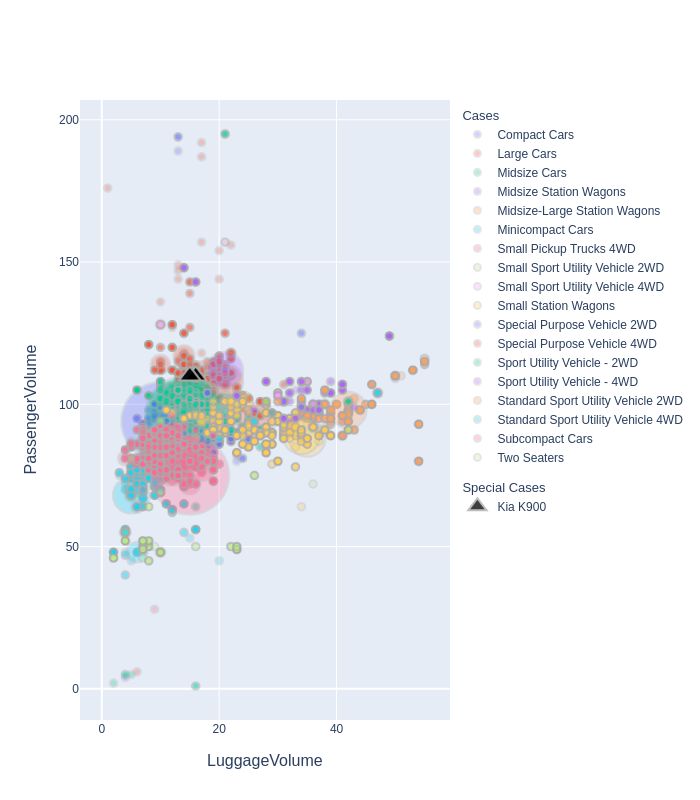

In [19]:
plot_dataset(
    convict_df, "LuggageVolume", "PassengerVolume",
    highlight_selection_conditions={"Make": "Kia", "Model": "K900"},
    highlight_label="Kia K900",
    alpha=0.3,
    hue="VehicleClass",
    size="convictions",
)

In [20]:
new_result['action']['VehicleClass'][0]

'Large Cars'

In [21]:
list(new_result['details'].keys())

['influential_cases',
 'feature_residuals',
 'feature_mda',
 'most_similar_cases',
 'action_features',
 'boundary_cases']

There is a LOT of information here, a few interesting bits:

1. Action value: This is the vehicle type
2. Most similar cases: These observations are a lot similar to our chosen car.
3. Boundary cases: These are observations on the 'edge' of being labeled with the class. This is our decision boundary.

## 3. Most similar cases / Boundary cases

In [22]:
most_similar_df = pd.DataFrame(new_result['details']['influential_cases'][0]).drop('VehicleClass', axis=1)

most_similar_records = pd.merge(most_similar_df, df_original, on=context_features, how='left')

cols_order = ['.influence_weight', '.session', '.session_training_index', 'Make', 'Model', 'Year'] + most_similar_records.columns.drop(['.session_training_index', '.session', '.influence_weight', 'Make', 'Model', 'Year']).tolist()

most_similar_records = most_similar_records.loc[ : , cols_order]
most_similar_records.head(10)

,.influence_weight,.session,.session_training_index,Make,Model,Year,PassengerVolume,DriveType,CityMPG,LuggageVolume,FuelType,HighwayMPG,VehicleClass
0,0.279588,545e46ea-1f58-4e06-897f-b5c8f8acb6d1,13273,Hyundai,Genesis,2014,109,Rear-Wheel Drive,18,16,Regular,27,Large Cars
1,0.214366,545e46ea-1f58-4e06-897f-b5c8f8acb6d1,14482,Kia,K900,2016,110,Rear-Wheel Drive,17,16,Regular,25,Large Cars
2,0.177433,545e46ea-1f58-4e06-897f-b5c8f8acb6d1,15110,Kia,K900,2017,110,Rear-Wheel Drive,17,16,Regular,25,Large Cars
3,0.172423,545e46ea-1f58-4e06-897f-b5c8f8acb6d1,10632,Hyundai,Genesis,2011,109,Rear-Wheel Drive,18,16,Regular,27,Large Cars
4,0.156189,545e46ea-1f58-4e06-897f-b5c8f8acb6d1,9915,Hyundai,Genesis,2010,109,Rear-Wheel Drive,18,16,Regular,27,Large Cars


<img src="data/Firstgen_K9.png" width="1080">

In [23]:
boundary_case_df = pd.DataFrame(new_result['details']['boundary_cases'][0]).drop('VehicleClass', axis=1)

boundary_records = pd.merge(boundary_case_df, df_original, on=context_features, how='inner')

cols_order = ['.influence_weight', '.session', '.session_training_index', 'Make', 'Model', 'Year'] + boundary_records.columns.drop(['.session_training_index',  '.session', '.influence_weight', 'Make', 'Model', 'Year']).tolist()

boundary_records = boundary_records.loc[ : , cols_order]
boundary_records.head(10)

,.influence_weight,.session,.session_training_index,Make,Model,Year,PassengerVolume,DriveType,CityMPG,LuggageVolume,FuelType,HighwayMPG,VehicleClass
0,0,545e46ea-1f58-4e06-897f-b5c8f8acb6d1,7953,Cadillac,STS,2008,102,Rear-Wheel Drive,17,14,Regular,26,Midsize Cars
1,0,545e46ea-1f58-4e06-897f-b5c8f8acb6d1,8138,Cadillac,CTS,2008,96,Rear-Wheel Drive,18,14,Regular,26,Midsize Cars
2,0,545e46ea-1f58-4e06-897f-b5c8f8acb6d1,8484,Cadillac,CTS,2009,97,Rear-Wheel Drive,18,14,Regular,26,Midsize Cars
3,0,545e46ea-1f58-4e06-897f-b5c8f8acb6d1,8489,Cadillac,STS,2009,102,Rear-Wheel Drive,17,14,Regular,26,Midsize Cars
4,0,545e46ea-1f58-4e06-897f-b5c8f8acb6d1,8895,Cadillac,CTS,2010,100,Rear-Wheel Drive,18,16,Regular,27,Midsize Cars
5,0,545e46ea-1f58-4e06-897f-b5c8f8acb6d1,8897,Cadillac,STS,2010,102,Rear-Wheel Drive,18,14,Regular,27,Midsize Cars
6,0,545e46ea-1f58-4e06-897f-b5c8f8acb6d1,10293,Cadillac,CTS,2010,100,Rear-Wheel Drive,16,16,Regular,26,Midsize Cars
7,0,545e46ea-1f58-4e06-897f-b5c8f8acb6d1,10596,Cadillac,CTS,2011,99,Rear-Wheel Drive,18,15,Regular,27,Midsize Cars
8,0,545e46ea-1f58-4e06-897f-b5c8f8acb6d1,10597,Cadillac,STS,2011,102,Rear-Wheel Drive,18,14,Regular,27,Midsize Cars
9,0,545e46ea-1f58-4e06-897f-b5c8f8acb6d1,10608,Cadillac,CTS,2011,99,Rear-Wheel Drive,16,15,Regular,26,Midsize Cars


Notice how similar the boundary case are to the chosen example (Kia K900), with the exception of the 'VehicleClass'. Also, the influence_weight are all '0' in this case indicating the case of interest does not lie on the boundary.

Let's plot and identify a similar and an edge case. Keep in mind we are only visualizing 2 of the 6 predictor variables. Therefore similar and boundary cases may not be right next to, or exactly on a class boundary, in the following plots.

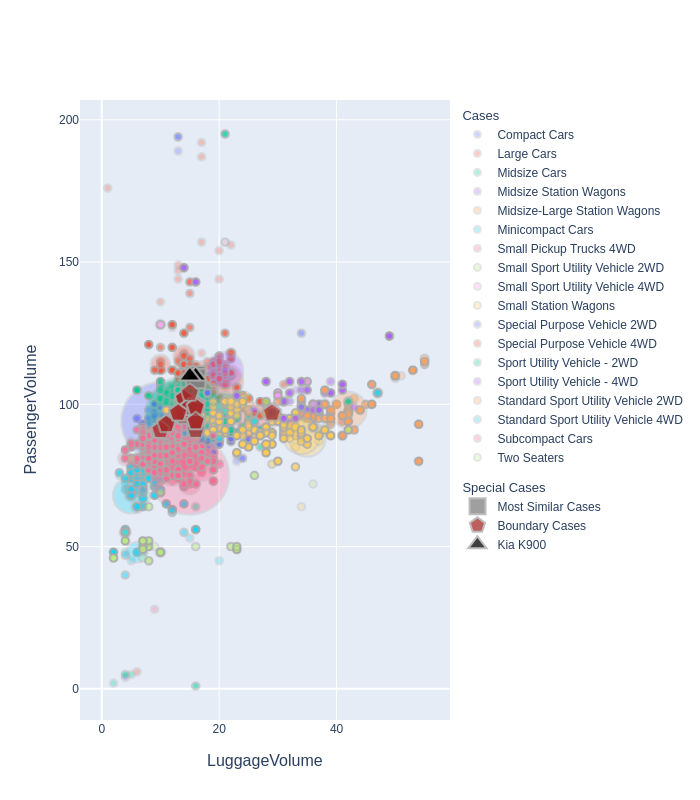

In [24]:
plot_dataset(
    convict_df, "LuggageVolume", "PassengerVolume",
    highlight_selection_conditions={"Make": "Kia", "Model": "K900"},
    highlight_label="Kia K900",
    alpha=0.3,
    hue="VehicleClass",
    size="convictions",
    most_similar_cases=most_similar_df,
    boundary_cases=boundary_case_df,
)

## 4. Feature relevancy metrics

Check the mean decrease in accuracy for the local model around the prediction:

In [25]:
new_result['details']['feature_mda'][0]

{'Year': 0.11600000000000008,
 'PassengerVolume': 0.2959999999999997,
 'DriveType': 0.028000000000000108,
 'CityMPG': 0.04800000000000007,
 'LuggageVolume': 0.17249999999999996,
 'FuelType': 0.03599999999999995,
 'HighwayMPG': 0.09799999999999995}

As observed from the 'most similar' and 'boundary' cases above, we can see that there were many vehicles which were similar to each other in that space. With the 'LuggageVolume' being a critical feature in distinguishing the VehicleClass in that region.

NOTE: the mda (mean decrease in accuracy) measures are approximations of the SHAP value.

Another informative comparison is to check the local residuals against the global residuals to understand the uncertainty and predictability of the features. 

In [26]:
feature_residuals_dicts = new_result['details']['feature_residuals']
feature_residuals = pd.DataFrame(list(feature_residuals_dicts[0].items()))
feature_residuals = feature_residuals.T
feature_residuals.columns = feature_residuals.loc[0]
feature_residuals = feature_residuals.drop(0, axis=0)
feature_residuals

,Year,VehicleClass,PassengerVolume,DriveType,CityMPG,LuggageVolume,FuelType,HighwayMPG
1,6.652941,0.433333,4.216478,0.707692,0.747368,1.315843,0.434477,1.653275


In [27]:
t.react_into_trainee(residuals=True)
t.get_prediction_stats(stats=['mae'])

,Year,VehicleClass,PassengerVolume,DriveType,CityMPG,LuggageVolume,FuelType,HighwayMPG
mae,5.263641,0.367232,4.34571,0.295939,2.005392,3.320266,0.251899,2.170708


The ‘Year’ feature jumps out in the above comparison – in the global residual the MAE was approximately 2, but in the localized region the MAE is much higher.

This is perhaps not a big surprise considering the cases we chose to investigate (Kia K900) which was a luxury car, which generally will have less variation year over year hence the ‘Year’ feature has less predictive power.


## 5. Low and high conviction comparisons

In [28]:
# helper function to extract out most similar and boundary cases
def get_info(case):
    details = {'most_similar_cases': True, 
               'num_most_similar_cases': 10, 
               'boundary_cases': True, 
               'num_boundary_cases': 10, 
               'influential_cases': True}
    
    new_result = t.react(case_indices=case, preserve_feature_values=context_features, leave_case_out=True, 
                         details=details, action_features=action_features)
    
    print('')   
    most_similar_df = pd.DataFrame(new_result['details']['influential_cases'][0]).drop('VehicleClass', axis=1)

    most_similar_records = pd.merge(most_similar_df, df_original, on=context_features, how='left')

    cols_order = ['.influence_weight', '.session', '.session_training_index', 'Make', 'Model', 'Year'] + most_similar_records.columns.drop(['.session_training_index', '.session', '.influence_weight', 'Make', 'Model', 'Year']).tolist()

    most_similar_records = most_similar_records.loc[ : , cols_order]

    print('Similar cases:')
    display(most_similar_records)
    
    boundary_case_df = pd.DataFrame(new_result['details']['boundary_cases'][0]).drop('VehicleClass', axis=1)

    boundary_records = pd.merge(boundary_case_df, df_original, on=context_features, how='inner')

    cols_order = ['.influence_weight', '.session', '.session_training_index', 'Make', 'Model', 'Year'] + boundary_records.columns.drop(['.session_training_index',  '.session', '.influence_weight', 'Make', 'Model', 'Year']).tolist()

    boundary_records = boundary_records.loc[ : , cols_order]
    print('Boundary cases:')
    display(boundary_records)

In [29]:
# pick a record from high / low conviction region
low_convict_record = convict_df.sort_values('convictions', ascending=True).iloc[0, :]
low_convict_case_index = [(low_convict_record['.session'], low_convict_record['.session_training_index'])]

high_convict_record = convict_df.sort_values('convictions', ascending=False).iloc[0, :]
high_convict_case_index = [(high_convict_record['.session'], high_convict_record['.session_training_index'])]

In [30]:
# low conviction record
low_convict_record

CityMPG                                                      77
DriveType                                     Front-Wheel Drive
FuelType                                            Electricity
HighwayMPG                                                   68
Make                                            CODA Automotive
Model                                                      CODA
Year                                                       2013
PassengerVolume                                              72
LuggageVolume                                                14
VehicleClass                                    Subcompact Cars
convictions                                            0.005618
.session_training_index                                   12462
.session                   545e46ea-1f58-4e06-897f-b5c8f8acb6d1
Name: 12462, dtype: object

In [31]:
get_info(low_convict_case_index)


Similar cases:


,.influence_weight,.session,.session_training_index,Make,Model,Year,PassengerVolume,DriveType,CityMPG,LuggageVolume,FuelType,HighwayMPG,VehicleClass
0,0.980714,545e46ea-1f58-4e06-897f-b5c8f8acb6d1,11727,CODA Automotive,CODA,2012,72,Front-Wheel Drive,77,14,Electricity,68,Subcompact Cars
1,0.005111,545e46ea-1f58-4e06-897f-b5c8f8acb6d1,15244,BYD,e6,2016,88,Front-Wheel Drive,73,16,Electricity,71,Small Sport Utility Vehicle 2WD
2,0.004919,545e46ea-1f58-4e06-897f-b5c8f8acb6d1,15741,BYD,e6,2017,88,Front-Wheel Drive,73,16,Electricity,71,Small Sport Utility Vehicle 2WD


Boundary cases:


,.influence_weight,.session,.session_training_index,Make,Model,Year,PassengerVolume,DriveType,CityMPG,LuggageVolume,FuelType,HighwayMPG,VehicleClass
0,0.000000,545e46ea-1f58-4e06-897f-b5c8f8acb6d1,12246,Ford,Focus Electric,2013,90,Front-Wheel Drive,110,14,Electricity,99,Compact Cars
1,0.000000,545e46ea-1f58-4e06-897f-b5c8f8acb6d1,13770,Mercedes-Benz,B-Class Electric Drive,2014,90,Front-Wheel Drive,85,22,Electricity,83,Midsize Cars
2,0.000000,545e46ea-1f58-4e06-897f-b5c8f8acb6d1,14207,Mercedes-Benz,B-Class Electric Drive,2015,90,Front-Wheel Drive,85,22,Electricity,82,Midsize Cars
3,0.000000,545e46ea-1f58-4e06-897f-b5c8f8acb6d1,14827,Mercedes-Benz,B250e,2016,90,Front-Wheel Drive,85,22,Electricity,82,Midsize Cars
4,0.005111,545e46ea-1f58-4e06-897f-b5c8f8acb6d1,15244,BYD,e6,2016,88,Front-Wheel Drive,73,16,Electricity,71,Small Sport Utility Vehicle 2WD
5,0.000000,545e46ea-1f58-4e06-897f-b5c8f8acb6d1,15369,Mercedes-Benz,B250e,2017,90,Front-Wheel Drive,85,22,Electricity,82,Midsize Cars
6,0.004919,545e46ea-1f58-4e06-897f-b5c8f8acb6d1,15741,BYD,e6,2017,88,Front-Wheel Drive,73,16,Electricity,71,Small Sport Utility Vehicle 2WD
7,0.004758,545e46ea-1f58-4e06-897f-b5c8f8acb6d1,16470,BYD,e6,2018,88,Front-Wheel Drive,73,16,Electricity,71,Small Sport Utility Vehicle 2WD
8,0.004498,545e46ea-1f58-4e06-897f-b5c8f8acb6d1,17714,BYD,e6,2020,88,Front-Wheel Drive,73,16,Electricity,71,Small Sport Utility Vehicle 2WD
9,0.000000,545e46ea-1f58-4e06-897f-b5c8f8acb6d1,17948,Porsche,Taycan Turbo S,2020,108,All-Wheel Drive,67,16,Electricity,68,Large Cars


In [32]:
# high conviction record
high_convict_record

CityMPG                                                      18
DriveType                                     Front-Wheel Drive
FuelType                                                Regular
HighwayMPG                                                   26
Make                                                 Mitsubishi
Model                                                    Galant
Year                                                       2002
PassengerVolume                                              96
LuggageVolume                                                14
VehicleClass                                       Midsize Cars
convictions                                         6147.209964
.session_training_index                                    4349
.session                   545e46ea-1f58-4e06-897f-b5c8f8acb6d1
Name: 4349, dtype: object

In [33]:
get_info(high_convict_case_index)


Similar cases:


,.influence_weight,.session,.session_training_index,Make,Model,Year,PassengerVolume,DriveType,CityMPG,LuggageVolume,FuelType,HighwayMPG,VehicleClass
0,0.236410,545e46ea-1f58-4e06-897f-b5c8f8acb6d1,4302,Daewoo,Leganza,2002,100,Front-Wheel Drive,18,14,Regular,26,Midsize Cars
1,0.190897,545e46ea-1f58-4e06-897f-b5c8f8acb6d1,1547,Chrysler,Cirrus,1996,96,Front-Wheel Drive,18,14,Regular,26,Midsize Cars
2,0.190897,545e46ea-1f58-4e06-897f-b5c8f8acb6d1,1547,Chrysler,Sebring Convertible,1996,96,Front-Wheel Drive,18,14,Regular,26,Midsize Cars
3,0.190897,545e46ea-1f58-4e06-897f-b5c8f8acb6d1,1547,Dodge,Stratus,1996,96,Front-Wheel Drive,18,14,Regular,26,Midsize Cars
4,0.190897,545e46ea-1f58-4e06-897f-b5c8f8acb6d1,1547,Plymouth,Breeze,1996,96,Front-Wheel Drive,18,14,Regular,26,Midsize Cars
5,0.190897,545e46ea-1f58-4e06-897f-b5c8f8acb6d1,1505,Chrysler,Cirrus,1996,96,Front-Wheel Drive,18,14,Regular,26,Midsize Cars
6,0.190897,545e46ea-1f58-4e06-897f-b5c8f8acb6d1,1505,Chrysler,Sebring Convertible,1996,96,Front-Wheel Drive,18,14,Regular,26,Midsize Cars
7,0.190897,545e46ea-1f58-4e06-897f-b5c8f8acb6d1,1505,Dodge,Stratus,1996,96,Front-Wheel Drive,18,14,Regular,26,Midsize Cars
8,0.190897,545e46ea-1f58-4e06-897f-b5c8f8acb6d1,1505,Plymouth,Breeze,1996,96,Front-Wheel Drive,18,14,Regular,26,Midsize Cars
9,0.190897,545e46ea-1f58-4e06-897f-b5c8f8acb6d1,1507,Chrysler,Cirrus,1996,96,Front-Wheel Drive,18,14,Regular,26,Midsize Cars


Boundary cases:


,.influence_weight,.session,.session_training_index,Make,Model,Year,PassengerVolume,DriveType,CityMPG,LuggageVolume,FuelType,HighwayMPG,VehicleClass
0,0,545e46ea-1f58-4e06-897f-b5c8f8acb6d1,407,Chrysler,LeBaron,1994,96,Front-Wheel Drive,18,14,Regular,26,Compact Cars
1,0,545e46ea-1f58-4e06-897f-b5c8f8acb6d1,3269,Nissan,Altima,2000,94,Front-Wheel Drive,18,14,Regular,26,Compact Cars
2,0,545e46ea-1f58-4e06-897f-b5c8f8acb6d1,4134,Chevrolet,Cavalier,2002,92,Front-Wheel Drive,18,13,Regular,26,Compact Cars
3,0,545e46ea-1f58-4e06-897f-b5c8f8acb6d1,4134,Pontiac,Sunfire,2002,92,Front-Wheel Drive,18,13,Regular,26,Compact Cars
4,0,545e46ea-1f58-4e06-897f-b5c8f8acb6d1,4193,Mercury,Cougar,2002,87,Front-Wheel Drive,18,14,Regular,26,Compact Cars
5,0,545e46ea-1f58-4e06-897f-b5c8f8acb6d1,4219,Oldsmobile,Alero,2002,93,Front-Wheel Drive,18,14,Regular,27,Compact Cars
6,0,545e46ea-1f58-4e06-897f-b5c8f8acb6d1,4226,Chevrolet,Cavalier,2002,92,Front-Wheel Drive,18,13,Regular,26,Compact Cars
7,0,545e46ea-1f58-4e06-897f-b5c8f8acb6d1,4226,Pontiac,Sunfire,2002,92,Front-Wheel Drive,18,13,Regular,26,Compact Cars
8,0,545e46ea-1f58-4e06-897f-b5c8f8acb6d1,6086,Pontiac,G6,2005,96,Front-Wheel Drive,19,14,Regular,26,Compact Cars
9,0,545e46ea-1f58-4e06-897f-b5c8f8acb6d1,6732,Pontiac,G6,2006,96,Front-Wheel Drive,19,14,Regular,26,Compact Cars
